# Bayesian Implementation of Spend Model

The purpose of this code is to implement a Spend model that can estimate how much money will be spent by a new account. The model is run with pymc3. 

In [36]:
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn import metrics
import seaborn as sns
from theano import shared

In [37]:
def run_model(model, m_name, trace_num=5000, tune=1000, display=True):
    with model:
        trace = pm.sample(trace_num, tune=tune)[tune:]
    if display:
        pm.plots.traceplot(trace)
    print("\nDIC: {}".format(pm.stats.dic(model=model, trace=trace)))
    #return({m_name : (model, trace)})
    return(trace)

In [30]:
# non-hierarchical 
with pm.Model() as model:
    betas = pm.Normal('betas', mu=0., sd=1.0, shape=len(model_feats))
    intercept = pm.Normal('Intercept', 0., sd=1.0)
    sigma = pm.HalfCauchy('sigma', beta=1)
    mu = intercept+pm.math.dot(betas, predictors)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, 
                        observed=X_sample['log_amount'])
model_dict['pooled'] = model

In [31]:
# hierarchical with channel fixed effects 
with pm.Model() as model:
    betas = pm.Normal('betas', mu=0., sd=1.0, shape=len(model_feats))
    ch_betas = pm.Normal('ch_betas', 0, sd=1.0, shape=len(products))
    sigma = pm.HalfCauchy('sigma', beta=1)
     
    mu = ch_betas[X_sample['product_idx'].values]+pm.math.dot(betas, X_sample[model_feats].values.T)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, observed=X_sample['log_amount'])
model_dict['ch_fe'] = model

In [66]:
# hierarchical with region fixed effects 
with pm.Model() as model:
    betas = pm.Normal('betas', mu=0., sd=1.0, shape=len(region_model_feats))
    reg_betas = pm.Normal('reg_betas', 0, sd=1.0, shape=len(f_list['region']))
    sigma = pm.HalfCauchy('sigma', beta=1)
     
    mu = reg_betas[X_sample['region_idx'].values]+pm.math.dot(betas, X_sample[region_model_feats].values.T)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, observed=X_sample['log_amount'])
model_dict['reg_fe'] = model

In [67]:
# hierarchical with channel+region fixed effects 
with pm.Model() as model:
    betas = pm.Normal('betas', mu=0., sd=1.0, shape=len(region_model_feats))
    ch_betas = pm.Normal('ch_betas', 0, sd=1.0, shape=len(products))
    reg_betas = pm.Normal('reg_betas', 0, sd=1.0, shape=len(f_list['region']))
    sigma = pm.HalfCauchy('sigma', beta=1)
     
    mu = ch_betas[X_sample['product_idx'].values]+\
    reg_betas[X_sample['region_idx'].values]+\
    pm.math.dot(betas, X_sample[region_model_feats].values.T)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, observed=X_sample['log_amount'])
model_dict['ch_reg_fe'] = model

In [69]:
trace_dict = {}
for m in model_dict:
    print(m)
    trace_dict[m] = run_model(model_dict[m], m, trace_num=5000, tune=2000, display=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


ch_reg_fe


100%|██████████| 7000/7000 [06:42<00:00, 17.38it/s]



DIC: 9863.81704661


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d00c7d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12a874a10>]], dtype=object)

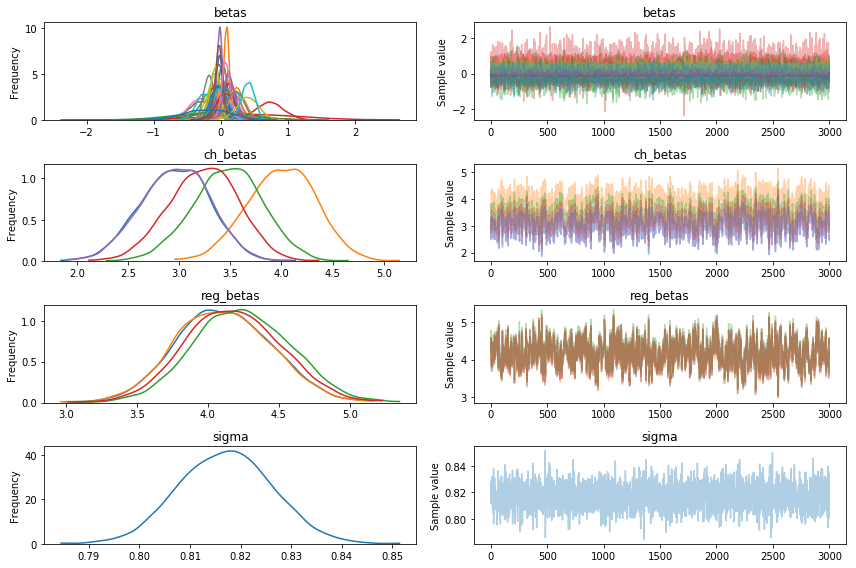

In [70]:
pm.traceplot(trace_dict[m])